# Natural Language Processing Course Project
### Politecnico di Milano, A.Y. 2024/2025

This notebook has been created for the Natural Language Processing course, held by Prof. Carman.

**Authors**:
* Matteo Figini
* Riccardo Figini
* Samuele Forner
* Caterina Motti
* Simone Zacchetti

The purpose of this notebook is to apply different NLP techniques to analyse the **RecipeNLG** dataset, you can find the dataset at the following [link](https://huggingface.co/datasets/mbien/recipe_nlg).

In [65]:
# Import useful libraries
import numpy as np
import pandas as pd
import os
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import random

# Preliminary analysis

In this section, we aim to perform a preliminary analysis of the dataset.
- Load and inspect the dataset: analyze which field are present, missing field or inconsistencies. 
- Analyze recipe distribution: compute statistics and visualize them.
- Analyze entities distribution: compute statistics and visualize them.

### Load and inspect the dataset

In [2]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/recipenlg/dataset/full_dataset.csv")
df

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [3]:
# Show the name of the columns
print("Columns:", df.columns.tolist())

Columns: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER']


Since the first column has no name, we renamed it:

In [4]:
df = df.rename(columns={'Unnamed: 0': 'id'})

In [5]:
# Dataset length
print(f"In the dataset there are {len(df)} different recipes!")

In the dataset there are 2231142 different recipes!


As we can see, the dataset contains 2231142 entries in 7 columns:
- id (int): ID.
- title (str): title of the recipe.
- ingredients (list of str): ingredients.
- directions (list of str): instruction steps.
- link (str): URL link.
- source (ClassLabel): origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    - "Gathered" (0): additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    - "Recipes1M" (1): recipes from the "Recipe1M+" dataset.
- NER (list of str): NER food entities.

Now, we check for **inconsistencies** and remove them if needed.

In [6]:
# Rows with missing values
rows_with_null = df.isnull().any(axis=1).sum()
print(f"There are {rows_with_null} rows with at least one null value.")
print(df.isnull().sum())

There are 1 rows with at least one null value.
id             0
title          1
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64


The missing value is a title, which is not a critical field. However, we prefer to remove it.

In [7]:
# Delete rows with at least one missing value
df.dropna()

,id,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [8]:
# Find duplicates by title
duplicate_counts = df['title'].value_counts()
print("Duplication results by: ", duplicate_counts)

Duplication results by:  title
Chicken Casserole                      4099
Broccoli Casserole                     3985
Squash Casserole                       2508
Cheese Ball                            2426
Zucchini Bread                         2298
                                       ... 
House Slytherin Key Lime Bars             1
Cheesy Loaded Hash Browns Casserole       1
Low Carb Mexican Chicken                  1
Old Fashioned Cocoa                       1
Polpette in Spicy Tomato Sauce            1
Name: count, Length: 1312870, dtype: int64


Here we have lots of duplicates. However, they might represent different variations of the same recipe which could be useful for further analysis.

Since the dataset is really big (2M+ entries), we decided to make a random subsampling of it by retaining only 25% (around half million entries).

In [9]:
# Randomly sample the dataset
df = df.sample(frac=0.25, random_state=42)

### Analyze vocaboulary

In [10]:
# Import necessary libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams

# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Define a new column 'text' with directions as a string
df['text'] = df['directions'].apply(lambda x: ' '.join(ast.literal_eval(x)))
all_instructions_list = df['text'].tolist()

# Preprocess the text and tokenize it into words
full_text = ' '.join(all_instructions_list)
full_text = full_text.lower()
full_text = re.sub(r'[^a-zA-Z0-9\s]', '', full_text)
words = full_text.split()

# Remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
words_nostopwords = [w for w in words if w not in stop_words]
tokens = [w for w in words_nostopwords]

# Generate bigrams and frequency distribution
bigram_list = list(bigrams(tokens))
bigram_fdist = FreqDist(bigram_list)

# Frequency distribution of words
fdist = FreqDist(words_nostopwords)

In [12]:
# Vocabulary size
vocabulary_size = len(fdist)
print("Vocabulary size: ", vocabulary_size)

# Average number of unique words per recipe
unique_words_per_recipe = []

for directions in df['text']:
    directions = directions.lower()
    directions = re.sub(r'[^a-zA-Z0-9\s]', '', directions)  # remove punctuation
    tokens = directions.split()  # split into words
    tokens = [w for w in tokens if w not in stop_words]
    unique_words = set(tokens)
    unique_words_per_recipe.append(len(unique_words))

avg_unique_words_per_recipe = sum(unique_words_per_recipe) / len(unique_words_per_recipe)    
print("Average number of unique words per recipe: ", avg_unique_words_per_recipe)

# Compute word length distribution
word_lengths = [len(word) for word in words_nostopwords]
avg_word_length = sum(word_lengths) / len(word_lengths)
min_word_length = min(word_lengths)
max_word_length = max(word_lengths)

print("Average word length: ", avg_word_length, " characters")
print("Minimum word length: ", min_word_length, " characters")
print("Maximum word length: ", max_word_length, " characters")

Vocabulary size:  112018
Average number of unique words per recipe:  43.36856787370067
Average word length:  5.285405950756063  characters
Minimum word length:  1  characters
Maximum word length:  262  characters


The high vocabulary size shows that the dataset is very rich and diverse, covering many ingredients, actions, and contextual descriptions. 

However the average number of unique words in each recipe is quite small: this suggests that each recipe tends to use a fairly concise and domain-specific subset.

NB: the maximum word length (262 characters) is likely an outlier. We must investigate it further. 

In [13]:
# Find the longest words
def find_long_words_in_directions(df):
    long_words = []
    
    for directions in df['text']:
        # Extract words longer than 45 characters, since in English vocabulary the longest word has 45 characters
        long_words.extend([word for word in directions.split() if len(word) > 45])
    
    if long_words:
        print("Found ", len(long_words), " long words in the dataset (greater than 45 characters).")
        print("Printing the first 10 for brevity: \n")
        print(long_words[:10])
    else:
        print("No words longer than 45 characters found.")

find_long_words_in_directions(df)

Found  620  long words in the dataset (greater than 45 characters).
Printing the first 10 for brevity: 

['https://food52.com/blog/3601-how-to-temper-chocolate', 'http://www.discountqueens.com/homemade-dry-onion-soup-mix/.', 'http://www.bonappetit.com/recipes/2012/04/nonna-consuelos-bolognese-sauce#ixzz1s9eVVHNG', 'http://leitesculinaria.com/99229/recipes-cinnamon-granola-bars.html#o3BvUmhKMCExxhX8.99', '(http://www.ehow.com/how_4731920_temper-an-egg.html).', 'https://cookpad.com/en/recipes/156069-kimchi-and-egg-rice-bowl-and-oyako-don-with-tinned-yakitori-chicken', 'https://cookpad.com/en/recipes/151167-sweet-savory-pork-rice-bowl', 'http://www.kitchenriffs.com/2013/06/the-dark-and-stormy-cocktail.html.', 'http://alldayidreamaboutfood.com/2012/04/maple-pecan-scones-low-carb-and-gluten-free.html', 'http://www.lowcarbmaven.com/easyrecipe-print/10109-0']


Most of them are links, so we can keep them (also considering that they are not that frequent).

In [14]:
# Create frequency distribution for bigrams
bigram_fdist = FreqDist(bigram_list)

# Display top 10 most common words
print("\nTop 10 most common words:")
for word, freq in fdist.most_common(10):
    print(f"{word}: {freq}")

# Display top 10 most common bigrams
print("\nTop 10 most common bigrams:")
for bigram, freq in bigram_fdist.most_common(10):
    print(f"{' '.join(bigram)}: {freq}")



Top 10 most common words:
add: 681360
minutes: 598142
heat: 396857
mix: 310106
cook: 277251
bowl: 275700
pan: 274190
stir: 272397
mixture: 272239
1: 265148

Top 10 most common bigrams:
salt pepper: 92694
preheat oven: 83194
5 minutes: 72573
10 minutes: 70488
set aside: 70229
medium heat: 62024
large bowl: 61419
30 minutes: 57096
olive oil: 52748
15 minutes: 52534


### Analyze recipes distribution
Since the recipes are the core of the dataset, it may be useful to analyse the length of each recipe to plot their distribution.

Recipes with very high or very low word counts might be outliers. Analyzing the distribution allows us to detect these outliers, which might skew our analysis. For instance, a recipe with only one word might be a mistake.

In [15]:
# Define a new column to count the number of words in 'directions'
df['dir_word_count'] = df['directions'].apply(lambda x: len(' '.join(x).split()))

In [16]:
# Retrieve the length and index of the longest and shortest recipe
max_words = df['dir_word_count'].max()
min_words = df['dir_word_count'].min()

max_words_idx = df['dir_word_count'].idxmax()
min_words_idx = df['dir_word_count'].idxmin()
print(f"Recipes' direction have between {min_words} and {max_words} words.")
print(f"The longest recipe has {max_words} words and it stands at location {max_words_idx}.")
#print(df['directions'].loc[max_words_idx])
print(df[['title','directions', 'dir_word_count']].loc[min_words_idx])

Recipes' direction have between 5 and 12375 words.
The longest recipe has 12375 words and it stands at location 1739457.
title             Seared Salmon, Carrot Tortellini, Red Pepper-C...
directions                                                    ["d"]
dir_word_count                                                    5
Name: 2119768, dtype: object


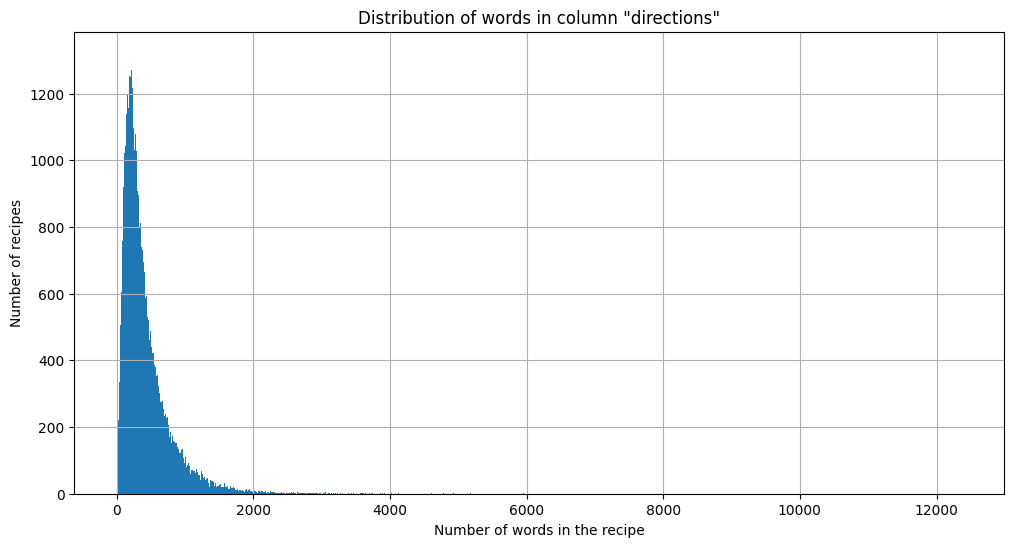

In [17]:
# Visualize the distribution of the number of words in column "directions" to show how long recipes are (in number of words)
plt.figure(figsize=(12,6))
plt.hist(df['dir_word_count'], bins=max_words, range=(0, max_words))
plt.title('Distribution of words in column \"directions\"')
plt.xlabel('Number of words in the recipe')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [18]:
# Analyzing recipe word count distribution
word_counts = df['dir_word_count'].dropna()
mean_word_count = word_counts.mean()
median_word_count = word_counts.median()
percentile_90 = word_counts.quantile(0.9)
percentile_95 = word_counts.quantile(0.95)

print(f"Mean word count: {mean_word_count}")
print(f"Median word count: {median_word_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean word count: 419.87529805337533
Median word count: 310.0
90th percentile: 855.0
95th percentile: 1118.0


In [19]:
# Count recipes with less than upper_threshold words
upper_threshold = 300
count_less_threshold = (word_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} words.")

48.45% of the recipes have at most 300 words.


In [20]:
# Count recipes with more than lower_threshold words
lower_threshold = 20
count_more_threshold = (word_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} words.")

99.95% of the recipes have at least 20 words.


### Analyze entities distribution
The aim of this section is to analyse the number of elements in the NER column, which contains the number of entities in each recipe, and to provide a distribution, giving a rough measure of the "complexity" of the recipe.

In [21]:
# Define a new column containing the number of entities of each recipe
ner_column = 'ner_len'
df[ner_column] = df['NER'].apply(lambda x: len(ast.literal_eval(x)))

In [22]:
# Retrieve the length and index of recipe with highest and lowest NER number
max_ner_len = df[ner_column].max()
min_ner_len = df[ner_column].min()

max_ner_len_idx = df[ner_column].idxmax()
print(f"Recipes have between {min_ner_len} and {max_ner_len} entities.")

print(f"The 'biggest' recipe has {max_ner_len} entities and it is at location {max_ner_len_idx}.")
#print(df['NER'].loc[max_ner_len_idx])

Recipes have between 0 and 402 entities.
The 'biggest' recipe has 402 entities and it is at location 719239.


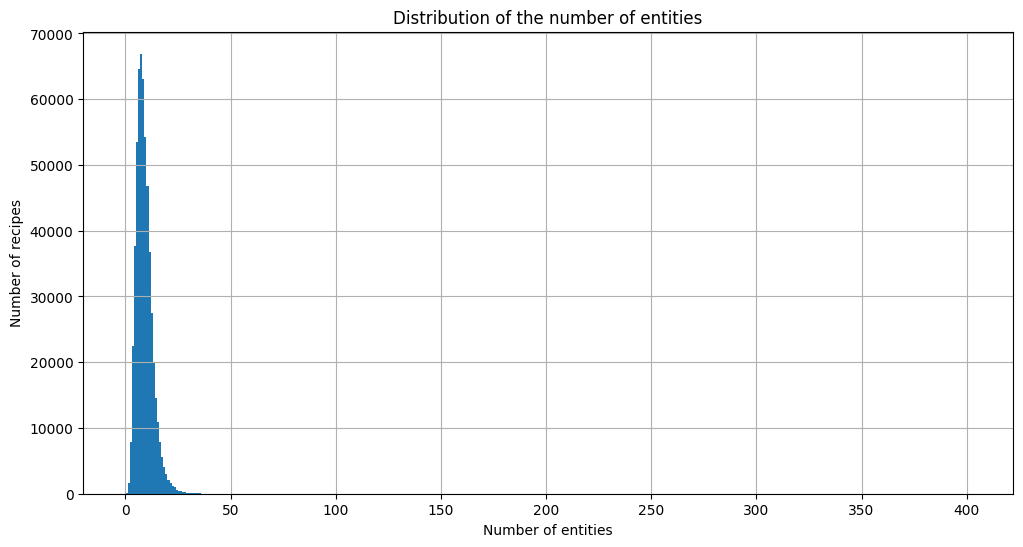

In [23]:
# Visualize the number of entities in each recipe
plt.figure(figsize=(12,6))
plt.hist(df[ner_column], bins=max_ner_len, range=(0, max_ner_len))
plt.title('Distribution of the number of entities')
plt.xlabel('Number of entities')
plt.ylabel('Number of recipes')
plt.grid(True)
plt.show()

In [24]:
# Analyzing recipe NER count distribution
entities_counts = df[ner_column].dropna()
mean_entities_count = entities_counts.mean()
median_entities_count = entities_counts.median()
percentile_90 = entities_counts.quantile(0.9)
percentile_95 = entities_counts.quantile(0.95)

print(f"Mean NER count: {mean_entities_count}")
print(f"Median NER count: {median_entities_count}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

Mean NER count: 8.482846468000272
Median NER count: 8.0
90th percentile: 13.0
95th percentile: 16.0


In [25]:
# Count recipes with less than upper_threshold entities
upper_threshold = 25
count_less_threshold = (entities_counts <= upper_threshold).sum()

upper_percentage = count_less_threshold/len(df) * 100

print(f"{round(upper_percentage, 2)}% of the recipes have at most {upper_threshold} entities.")

99.72% of the recipes have at most 25 entities.


In [26]:
# Count recipes with more than lower_threshold entities
lower_threshold = 3
count_more_threshold = (entities_counts >= lower_threshold).sum()

lower_percentage = count_more_threshold/len(df) * 100

print(f"{round(lower_percentage, 2)}% of the recipes have at least {lower_threshold} entities.")

98.27% of the recipes have at least 3 entities.


In [27]:
# Filter recipes where there are NO NER
zero_NER_recipes = df[df['ner_len'] == 0]

print(zero_NER_recipes[['title', 'NER']])
# Drop recipes where there are no NERs
df = df[df['ner_len'] != 0]

                                                     title NER
1795606                                        Aromatic Fu  []
2099220                                  Roasting Squashes  []
2134230                               Biscuit Pocket Bread  []
1342271                                       Duck Breast   []
1821196                                     Baby Back Ribs  []
...                                                    ...  ..
1337658  Spaghetti With Olives, Dried Chillies And Pang...  []
407311                                        Unfried Pies  []
1383058            Traditional Armenian Dish - Lamb Recipe  []
1735481                                          Asparagus  []
1285166  Cauliflower  Broccoli Dish With Bacon And Che...  []

[128 rows x 2 columns]


It means that the NER process didn't detect any entities for these recipes. This could happen for various reasons, such as:
- The recipe doesn't contain recognizable entities like ingredients, amounts, or special terms.
- The NER process might not be comprehensive enough to detect all relevant entities in the recipe.
- The recipe could be incomplete or malformed in a way that prevents proper entity recognition.

For this reason, we decided to drop these rows.

NB: It may happens that there are NO entries without NER, since we are using a subsample of the original dataset. 

## Clustering

Now we want to perform some clustering analysis.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [29]:
vectorizer = TfidfVectorizer(stop_words='english')
titles = df['title'].astype(str)
X = vectorizer.fit_transform(titles)

In [30]:
inertia = []
k_values = list(range(2, 50))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

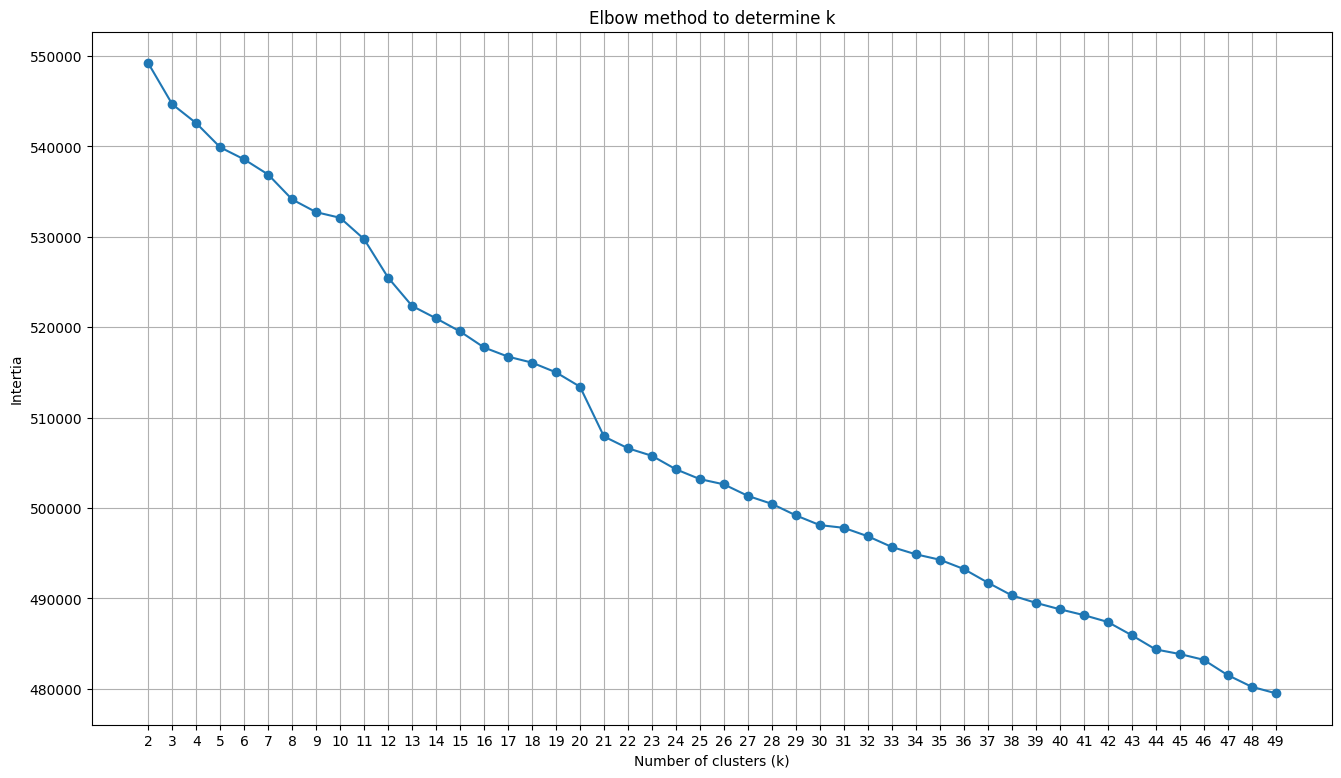

In [31]:
plt.figure(figsize=(16, 9))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow method to determine k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Intertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

It seems that two interesting values for K are 13 and 21, let's try both of them.

In [32]:
n_clusters = 13
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

# Add clusters to the original dataframe
df['cluster'] = kmeans.labels_

# Print an example of titles grouped by cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
                   Pol Martin Scrambled Eggs Magda
         Crispy Parmesan Polenta With Poached Eggs
Skillet Eggs With Tomatoes, Parmigiano-Reggiano...
         Spiced Coconut Lentils with Peppered Eggs
                            Poached Eggs In Catsup

Cluster 1:
      French Chicken Stew
          Moms Pie Dough 
          Nutty Butty Pie
    Extra Flaky Pie Crust
Puerto Rican Chicken Soup

Cluster 2:
             Pretzel Salad Or Dessert
Crab, Grapefruit And Watercress Salad
                      Vegetable Salad
               Russian Salad Dressing
            Rice And Asparagus Salad 

Cluster 3:
         Barbecued Beef Brisket Recipe
Beef Stew With Potatoes, Spanish Style
              Easy cheese and beef dip
                Deli Corned Beef Bites
              Classic Beef Wellingtons

Cluster 4:
                   Marinated Flank Steak Recipe
                           Chinese Pepper Steak
Tex-Mex Steak Calzones (Sandwich) Pizza Pockets
                          

In [33]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[titles.iloc[j] for j in sorted_terms[:10]]

['Dirt Cake',
 'Hummingbird Cake',
 'Snowman Cups',
 'Delicious Beef',
 'Low-Fat Baked Chicken(Heart Healthy)  ',
 'Butter Cake',
 "World's Best Beer Margarita's",
 'Kichadi',
 'Kassler Chops With Remoulade',
 'Green Bean Salad With Creamy Dressing']

In [34]:
n_clusters = 21
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(X)

df['cluster'] = kmeans.labels_

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
                   Pol Martin Scrambled Eggs Magda
         Crispy Parmesan Polenta With Poached Eggs
Skillet Eggs With Tomatoes, Parmigiano-Reggiano...
         Spiced Coconut Lentils with Peppered Eggs
                            Poached Eggs In Catsup

Cluster 1:
                 Moms Pie Dough 
                 Nutty Butty Pie
           Extra Flaky Pie Crust
Chicken With Mango And Asparagus
                       Smore Pie

Cluster 2:
                         Sloppy Joe Grilled Cheese
                             Cinnamon Cheese Toast
Balsamic Brussels Sprouts With Feta Cheese And ...
                  Grandma'S Cheese Balls W/Olives 
                                   Cheese Broccoli

Cluster 3:
         Marinated Flank Steak Recipe
                       Glazed Carrots
                         Citrus Syrup
Cranberry And Candied Orange Chutney 
Tau Kua He Ci Medan'S Favourite Food 

Cluster 4:
                               Stuffed Mushrooms
     Simple Stuffed Shells

In [35]:
centroid = kmeans.cluster_centers_[0]

sorted_terms = centroid.argsort()[::-1]

[titles.iloc[j] for j in sorted_terms[:20]]

['Dirt Cake',
 'Hummingbird Cake',
 'Snowman Cups',
 'Delicious Beef',
 'Low-Fat Baked Chicken(Heart Healthy)  ',
 'Butter Cake',
 "World's Best Beer Margarita's",
 'Kassler Chops With Remoulade',
 'Green Bean Salad With Creamy Dressing',
 'Mashed Rutabagas And Potatoes',
 'Kichadi',
 'Arugula Soup Related Story',
 'Turkey Tetrazzini',
 'Diabetic Turkey Patties',
 "Loretta's Frozen Dessert",
 'Banana Split Cake',
 'Prune Cake',
 'Summer Fresh Spinach Salad',
 'Crock Pot Yogurt',
 'Peanut Butter Fudge']

In [36]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['eggs', 'deviled', 'scrambled', 'pickled', 'baked']
Cluster 1:	['chicken', 'pie', 'pecan', 'lemon', 'pot']
Cluster 2:	['cheese', 'ball', 'cream', 'macaroni', 'goat']
Cluster 3:	['recipe', 'chocolate', 'beef', 'rice', 'pork']
Cluster 4:	['stuffed', 'peppers', 'mushrooms', 'shells', 'chicken']
Cluster 5:	['fruit', 'muffins', 'salad', 'bran', 'blueberry']
Cluster 6:	['casserole', 'chicken', 'broccoli', 'potato', 'rice']
Cluster 7:	['dip', 'spinach', 'artichoke', 'cheese', 'hot']
Cluster 8:	['peanut', 'butter', 'cookies', 'chocolate', 'fudge']
Cluster 9:	['soup', 'potato', 'vegetable', 'bean', 'chicken']
Cluster 10:	['cake', 'chocolate', 'pound', 'apple', 'carrot']
Cluster 11:	['sauce', 'barbecue', 'spaghetti', 'tomato', 'chicken']
Cluster 12:	['dollar', 'million', 'pie', 'fudge', 'pound']
Cluster 13:	['cream', 'ice', 'sour', 'pie', 'cake']
Cluster 14:	['french', 'toast', 'onion', 'soup', 'bread']
Cluster 15:	['easy', 'chicken', 'quick', 'pie', 'cake']
Cl

In [37]:
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of docs in: 
Cluster 0: 2531
Cluster 1: 48292
Cluster 2: 16528
Cluster 3: 281323
Cluster 4: 5854
Cluster 5: 10729
Cluster 6: 20671
Cluster 7: 10226
Cluster 8: 8258
Cluster 9: 16404
Cluster 10: 26620
Cluster 11: 16723
Cluster 12: 225
Cluster 13: 9695
Cluster 14: 2972
Cluster 15: 9810
Cluster 16: 14755
Cluster 17: 5348
Cluster 18: 3625
Cluster 19: 15076
Cluster 20: 31993


### Evaluation

In order to evaluate our clustering we are using only intrinsic method, since we do not have the real labels of the clusters.

In [38]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(X, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 507911.4189022362


Since the dataset is quite big, even reducing it to a quarter of the original, we try to perform also a Mini Batch Clustering.

In [39]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 21
mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters,batch_size=500, random_state=2307)
mb_kmeans.fit(X)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=500, n_clusters=21, random_state=2307)

In [40]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(mb_kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(X, mb_kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 509374.4754996095


Now, let's try to visualize clusters.

In [41]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(X)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.03293261, 0.23702507, 0.00744723, ..., 0.02959339, 0.00770553,
        0.0458583 ]),
 array([ 0.02075781, -0.04483762,  0.0044519 , ...,  0.01337162,
         0.00096857,  0.02399378]),
 array([ 0.00979351,  0.00298949,  0.00058668, ..., -0.00499413,
        -0.00165388, -0.01820298])]

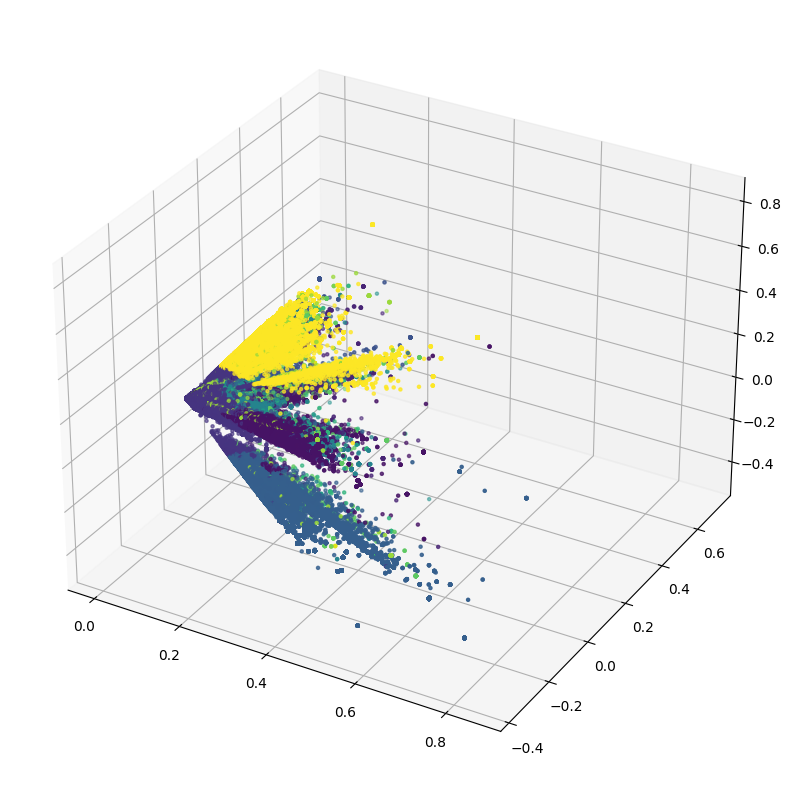

In [42]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.')

## Indexing
We decided to index the recipes based on the directions, in order to perform keyword search over them. We choose the directions since they will likely contains both ingredients and keywords relative to the procedure (e.g. baked, fried).

In [43]:
!pip install -q python-terrier==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 2.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 17.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00


In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import pyterrier as pt

if not pt.started():
  pt.init()

/tmp/ipykernel_31/2460995692.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_31/2460995692.py:6: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [45]:
# Create a list of documents (use 'title' for indexing)
documents_title = [{'docno': str(i), 'text': text} for i, text in enumerate(df['title'])]

# Create the index
indexer = pt.IterDictIndexer("./index_title")
indexer.index(documents_title)

09:21:39.047 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (194) - further warnings are suppressed
09:22:05.203 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 46 empty documents


<org.terrier.querying.IndexRef at 0x7c23f786e870 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x6f054930 at 0x7c23f7856db0>>

In [46]:
# Create a list of documents (use 'directions' for indexing)
documents_directions = [{'docno': str(i), 'text': text} for i, text in enumerate(df['directions'])]

# Create the index
indexer = pt.IterDictIndexer("./index_directions")
indexer.index(documents_directions)

09:22:16.508 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (61876) - further warnings are suppressed
09:23:39.725 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 4 empty documents


<org.terrier.querying.IndexRef at 0x7c23f76e7470 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x6f054928 at 0x7c2199c920b0>>

In [47]:
# Create documents with multiple fields
documents_fields = [
    {
        'docno': str(i),
        'title': row['title'],
        'ingredients': row['ingredients'],
        'directions': row['directions']
    }
    for i, row in df.iterrows()
]

# Index the fielded documents
indexer_fields = pt.IterDictIndexer("./index_fields")

# Set meta fields and indexed fields
indexref = indexer_fields.index(
    documents_fields,
    fields=["title", "ingredients", "directions"],  
    meta={'docno': 20, 'title': 512, 'ingredients': 1024, 'directions': 4096}
)

In [48]:
# Create a searcher using the index
index_title = pt.IndexFactory.of("./index_title")
index_directions = pt.IndexFactory.of("./index_directions")
index_fields = pt.IndexFactory.of(indexref)

# BM25 retrieval model
bm25_tit = pt.terrier.Retriever(index_title, wmodel="BM25")
bm25_dir = pt.terrier.Retriever(index_directions, wmodel="BM25")

# TF-IDF retrieval model
tfidf_tit = pt.terrier.Retriever(index_title, wmodel="TF_IDF")
tfidf_dir = pt.terrier.Retriever(index_directions, wmodel="TF_IDF")

# DFRee retrieval model (Document Frequency based)
dfree_tit = pt.terrier.Retriever(index_title, wmodel="DFRee")
dfree_dir = pt.terrier.Retriever(index_directions, wmodel="DFRee")

# Create BM25F retriever with field weights
# Weighted BM25 over each field
bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")

# Weighted combination of scores: BM25F-like
bm25f_manual = (
    bm25_title * 0.3 +
    bm25_ingredients * 0.4 +
    bm25_directions * 0.3
)

/tmp/ipykernel_31/1696475414.py:20: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
/tmp/ipykernel_31/1696475414.py:21: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
/tmp/ipykernel_31/1696475414.py:22: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")


By using all of these models, we can perform a comprehensive evaluation of the different retrieval strategies. Each model captures different aspects of relevance:

- BM25 accounts for both term and document frequencies, providing a balanced relevance score.
- TF-IDF emphasizes the importance of rare terms across the document collection.
- DFRee is useful for understanding how document frequency affects relevance.

We also tried BM25 without term frequency (no tf), but it performed to same as classic BM25. This is likely because in our dataset, document length and term frequency did not vary significantly across relevant documents, so removing the tf component had minimal impact on ranking.
To keep the notebook clean we omitted this variant.

In [49]:
print(index_title.getCollectionStatistics().toString())
print(index_directions.getCollectionStatistics().toString())
print(index_fields.getCollectionStatistics().toString())

Number of documents: 557658
Number of terms: 34052
Number of postings: 1858185
Number of fields: 1
Number of tokens: 1866522
Field names: [text]
Positions:   false

Number of documents: 557658
Number of terms: 51014
Number of postings: 22765411
Number of fields: 1
Number of tokens: 30936907
Field names: [text]
Positions:   false

Number of documents: 557658
Number of terms: 79122
Number of postings: 32573688
Number of fields: 3
Number of tokens: 55465563
Field names: [title, ingredients, directions]
Positions:   false



In [60]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models for the titles including BM25F
    result_bm25_tit = bm25_tit.search(q['query'])
    result_tfidf_tit = tfidf_tit.search(q['query'])
    result_dfree_tit = dfree_tit.search(q['query'])   

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25_tit),
        ("TF-IDF", result_tfidf_tit),
        ("DFRee", result_dfree_tit),
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, (docno, score) in enumerate(zip(result["docno"][:5], result["score"][:5])):
            docno_int = int(docno)  # Convert from str to int
            title = df['title'].iloc[docno_int] if docno_int < len(df) else "TITLE NOT FOUND"
            print(f"DocNO: {docno:<7} | Title: {title:<50.48} | Score: {score:.4f}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title,
                'Score': score
            })


=== Query 1: chicken casserole ===

--- Method: BM25 ---
DocNO: 345320  | Title: Chicken Casserole With No Chicken                  | Score: 9.7953
DocNO: 592     | Title: Chicken Casserole                                  | Score: 9.7166
DocNO: 617     | Title: Chicken Casserole                                  | Score: 9.7166
DocNO: 749     | Title: Chicken Casserole                                  | Score: 9.7166
DocNO: 789     | Title: Chicken Casserole                                  | Score: 9.7166

--- Method: TF-IDF ---
DocNO: 345320  | Title: Chicken Casserole With No Chicken                  | Score: 5.5855
DocNO: 592     | Title: Chicken Casserole                                  | Score: 5.5251
DocNO: 617     | Title: Chicken Casserole                                  | Score: 5.5251
DocNO: 749     | Title: Chicken Casserole                                  | Score: 5.5251
DocNO: 789     | Title: Chicken Casserole                                  | Score: 5.5251

--- Met

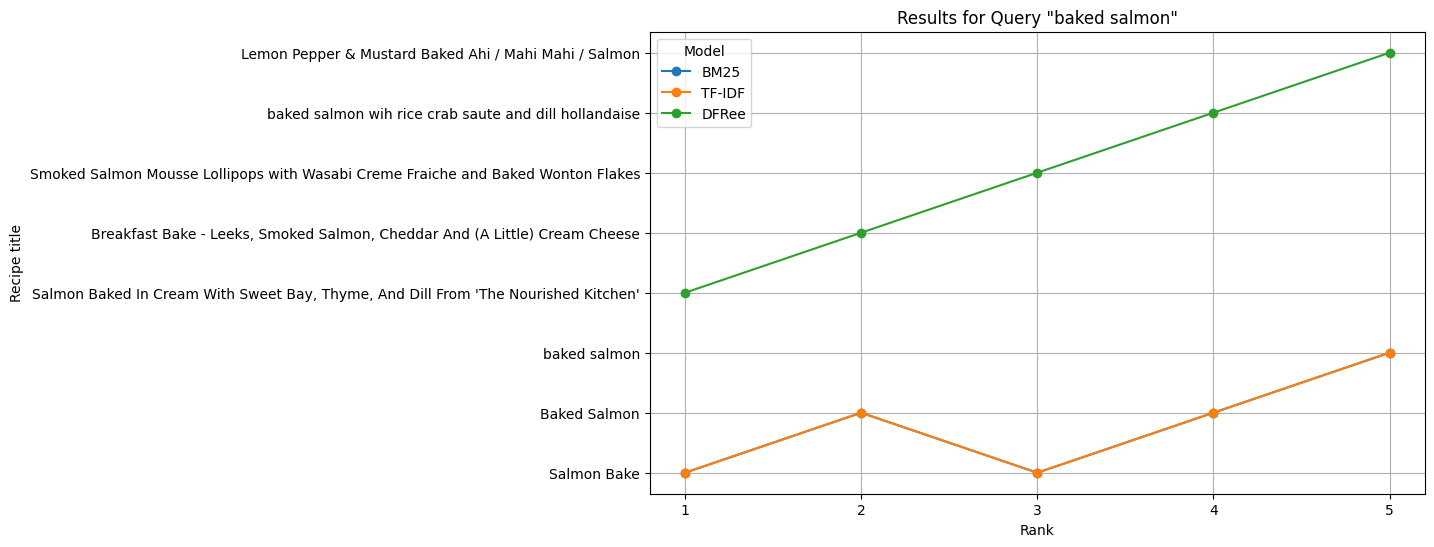

In [61]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

In this case, BM25 and TF-IDF yielded the same document rankings: this happen when documents are short, uniformly sized, or when term frequencies are relatively balanced, making the additional complexity of BM25 less impactful.

This suggest that relying only on document titles for indexing provides limited term variability and context, reducing the effectiveness of retrieval models. Incorporating richer textual content would likely yield more discriminative and informative rankings.

In [62]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models for the directions including BM25F
    result_bm25_dir = bm25_dir.search(q['query'])
    result_tfidf_dir = tfidf_dir.search(q['query'])
    result_dfree_dir = dfree_dir.search(q['query'])
    
    result_bm25f = bm25f_manual.search(q['query'])  

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25_dir),
        ("TF-IDF", result_tfidf_dir),
        ("DFRee", result_dfree_dir),
        ("BM25F", result_bm25f) 
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, (docno, score) in enumerate(zip(result["docno"][:5], result["score"][:5])):
            docno_int = int(docno)  # Convert from str to int
            title = df['title'].iloc[docno_int] if docno_int < len(df) else "TITLE NOT FOUND"
            print(f"DocNO: {docno:<7} | Title: {title:<50.48} | Score: {score:.4f}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title,
                'Score': score
            })


=== Query 1: chicken casserole ===


TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00, 10.93q/s]



--- Method: BM25 ---
DocNO: 60998   | Title: Bob'S Deluxe Chicken                               | Score: 13.0446
DocNO: 504597  | Title: Lennie'S Chicken And Rice                          | Score: 12.8793
DocNO: 329261  | Title: Quick Chicken Pot Pie                              | Score: 12.7703
DocNO: 444448  | Title: Kings Ranch Chicken Casserole                      | Score: 12.6632
DocNO: 130370  | Title: Chicken Enchiladas                                 | Score: 12.6103

--- Method: TF-IDF ---
DocNO: 60998   | Title: Bob'S Deluxe Chicken                               | Score: 7.5363
DocNO: 504597  | Title: Lennie'S Chicken And Rice                          | Score: 7.4334
DocNO: 329261  | Title: Quick Chicken Pot Pie                              | Score: 7.3705
DocNO: 444448  | Title: Kings Ranch Chicken Casserole                      | Score: 7.3189
DocNO: 432678  | Title: Chicken Stuffing Dressing Casserole                | Score: 7.2895

--- Method: DFRee ---
DocNO: 444448  |

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00, 11.94q/s]



--- Method: BM25 ---
DocNO: 470068  | Title: Tiny Fruitcakes                                    | Score: 25.9762
DocNO: 318994  | Title: Decorative Icing                                   | Score: 25.0310
DocNO: 358491  | Title: Popcorn Balls(That Stay Soft)                      | Score: 23.1175
DocNO: 65593   | Title: Cranberry Sparkler                                 | Score: 21.9359
DocNO: 483258  | Title: Aperol Spritz                                      | Score: 21.9359

--- Method: TF-IDF ---
DocNO: 470068  | Title: Tiny Fruitcakes                                    | Score: 14.3295
DocNO: 318994  | Title: Decorative Icing                                   | Score: 13.7896
DocNO: 358491  | Title: Popcorn Balls(That Stay Soft)                      | Score: 12.7574
DocNO: 65593   | Title: Cranberry Sparkler                                 | Score: 12.0845
DocNO: 483258  | Title: Aperol Spritz                                      | Score: 12.0845

--- Method: DFRee ---
DocNO: 2890

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00,  9.79q/s]


--- Method: BM25 ---
DocNO: 233225  | Title: Yummy Salmon                                       | Score: 13.5911
DocNO: 300496  | Title: Balsamic Glazed Salmon                             | Score: 13.4915
DocNO: 69969   | Title: Lavender Honey Salmon                              | Score: 13.4665
DocNO: 102573  | Title: Oven-baked salmon                                  | Score: 13.4624
DocNO: 418148  | Title: Fennel- And Dill-Rubbed Grilled Salmon             | Score: 13.4031

--- Method: TF-IDF ---
DocNO: 300496  | Title: Balsamic Glazed Salmon                             | Score: 8.5427
DocNO: 418148  | Title: Fennel- And Dill-Rubbed Grilled Salmon             | Score: 8.4817
DocNO: 69969   | Title: Lavender Honey Salmon                              | Score: 8.4575
DocNO: 385339  | Title: Lemon-Pepper Salmon Ii                             | Score: 8.3448
DocNO: 287067  | Title: Baked Salmon with Black Olive Salsa                | Score: 8.2992

--- Method: DFRee ---
DocNO: 418148  |

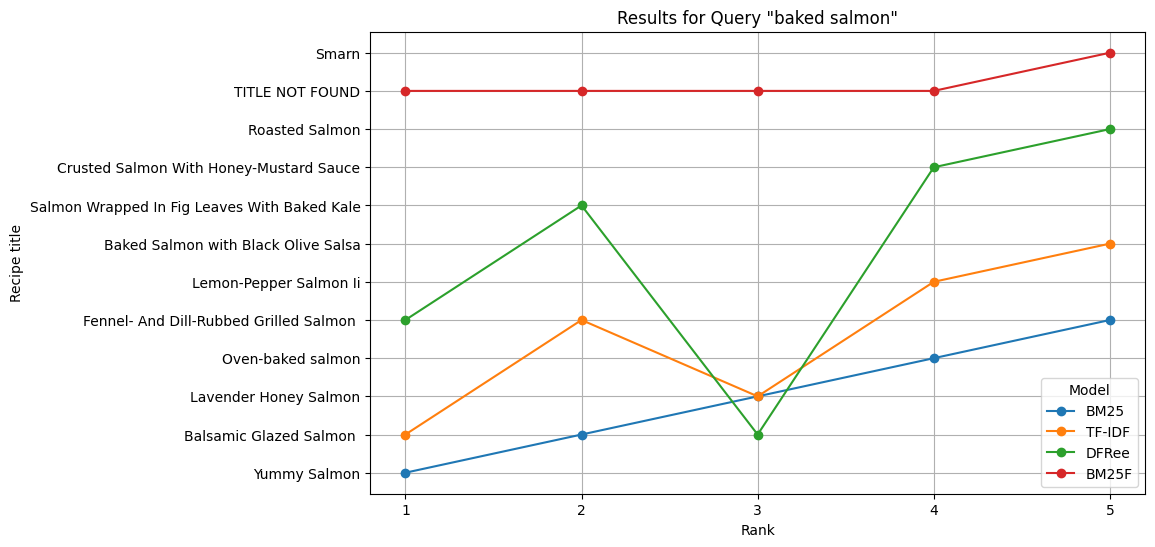

In [63]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

About the results:

- TF-IDF put “Balsamic Glazed Salmon” at #1: we can see that TF-IDF’s emphasis on rare terms may be boosting “balsamic”.
- DFRee puts “Fennel-And-Dill-Rubbed Grilled Salmon” at #1, and then “Salmon Wrapped In Fig Leaves With Baked Kale” at #2: it shows that rarer, longer titles win more weight under DFRee.
- Unlike single-field models, BM25F combines weighted evidence from different parts of the document, making it robust when key terms appear in both title, ingredients and directions.

## Word2Vec

First thing first, we need a list

In [66]:
w2v_directions = list(df['text'])

# Reduce the size of the data 
subset_size = len(w2v_directions) // 10

subset_directions = random.sample(w2v_directions, subset_size)

print(len(subset_directions))

55765


Now let's tokenize each remaining direction to have the right format for our World2Vec model



In [67]:
tokenized_directions = [re.sub('\W', ' ', direction).lower().split() for direction in subset_directions]

Let's remove the stopwords
(we need a context window to train it, so we are discarding the directions composed by only one word)

In [68]:
filtered_directions = [[word for word in sublist if word not in stop_words] for sublist in tokenized_directions]
filtered_directions = [direction for direction in filtered_directions if len(direction) > 1]

55755


Now it's time to  train our model!


In [69]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(filtered_directions, vector_size=50, min_count=5, window=10)

len(model.wv)

7345

Ever wondered what is a possible vector representation of the word soup?  Me neither!

In [70]:
term = 'soup'
model.wv[term]

array([ 0.17771186, -2.9909508 ,  1.1474848 , -3.0732317 ,  2.4182012 ,
        1.6675435 , -2.9141147 ,  1.9722545 , -0.11058386, -2.9455018 ,
       -1.5017879 , -0.38437003,  3.378444  , -2.4771008 ,  4.6210594 ,
       -0.9913077 ,  0.41343132, -0.0518739 ,  4.6521873 , -1.3135246 ,
        1.606971  , -1.5992186 , -5.834787  ,  0.5940236 , -1.2783436 ,
        1.3862303 ,  1.9823893 ,  2.8653154 ,  0.7216959 ,  0.05437583,
       -1.4777595 , -7.563944  ,  1.6237991 , -0.8642904 ,  5.066931  ,
       -1.8140359 , -1.0324502 ,  5.5507393 , -3.6368053 , -0.46921372,
        1.8470684 , -3.7716963 ,  0.34329927,  1.7081871 ,  1.3889251 ,
        0.8321518 ,  3.342119  ,  0.14872095,  6.373358  , -0.40192878],
      dtype=float32)

Or what are the most similar words to 'chicken' (Between the ones in our dataset)

In [71]:
term = 'chicken'
model.wv.most_similar(term)

[('breasts', 0.7477666735649109),
 ('turkey', 0.6710565090179443),
 ('rabbit', 0.6338600516319275),
 ('vegetables', 0.6092067360877991),
 ('breast', 0.5890929102897644),
 ('wings', 0.5859465599060059),
 ('meat', 0.5682283043861389),
 ('pork', 0.5673868060112),
 ('stuffing', 0.5667983889579773),
 ('thighs', 0.5642074346542358)]

From 0 to 1, how  similar the words chicken and beef are?

In [72]:
model.wv.similarity('chicken', 'beef')

0.4439417

chicken:breast = beef:?

In [73]:
vec = model.wv['beef'] + model.wv['breast'] - model.wv['chicken']
model.wv.similar_by_vector(vec)

[('corned', 0.6791134476661682),
 ('beef', 0.6713929176330566),
 ('chuck', 0.668399453163147),
 ('meat', 0.6009801626205444),
 ('lean', 0.5979657769203186),
 ('chipped', 0.5643017292022705),
 ('tenderizer', 0.5576048493385315),
 ('ground', 0.5515400767326355),
 ('sirloin', 0.5491594672203064),
 ('mallet', 0.5480726361274719)]

Right now we are working with embedding vectors of 50 dimensions. Unfortunately, the human brain is limited and can visualize only up to three of them. So it's necessary to reduce our vectors' dimensions to this number. Let's try to do so using t-distributed stochastic neighbor embedding (t-SNE):

In [74]:
from sklearn.manifold import TSNE

In [75]:
samples = random.sample(list(model.wv.key_to_index), 1000)
vectors = model.wv[samples]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(vectors)

In [76]:
x, y, z = np.transpose(tsne_embedding)

In [79]:
import plotly.express as px

fig = px.scatter_3d(x=x[:300],y=y[:300],z=z[:300],text=samples[:300])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Quite interesting isn't it? 

Numbers are near each other (probably they represent different oven temperatures). Also values like 9x5x3 and 2x3 (lengths of the baking trays?).

Same for fruits and vegetables

Why don't we try principal component analysis to perform the dimensionality reduction?

(and also sample again, you never know)

In [80]:
from sklearn.decomposition import PCA

In [81]:
samples = random.sample(list(model.wv.key_to_index), 1000)
vectors = model.wv[samples]

pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(vectors)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}" )
print(f"Total explained variance: {sum(explained_variance_ratio)}")

Explained variance ratio: [0.08683705 0.06373877 0.06038148]
Total explained variance: 0.21095730364322662


In [82]:
x, y, z = np.transpose(pca_embedding)

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=samples[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

The 3 dimensions that hold the most informations tent to agglomerate around the values (0,0,0), making pca reductions not suited for visualisation purposes
